In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from fbprophet import Prophet

%matplotlib inline
%config Completer.use_jedi = False

According to the Facebook Prophet article, it was designed to predict a large number of different business indicators and builds fairly good default forecasts. In addition, the library makes it possible to improve the forecast by changing human-understandable parameters and does not require analysts to have deep knowledge of the structure of predictive models.


Let's talk a little about how the Prophet library works. In fact, this is an additive regression model, consisting of the following components:


$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$


The seasonal components of $s(t)$ are responsible for modeling the periodic changes associated with weekly and annual seasonality. Weekly seasonality is modeled using dummy variables. 6 additional features are added, for example, [monday, tuesday, wednesday, thursday, friday, saturday], which take values ​​0 and 1 depending on the date. The sign sunday corresponding to the seventh day of the week is not added because it will depend linearly on the other days of the week and this will affect the model.
Annual seasonality is modeled by Fourier series.
The $g(t)$ trend is a piecewise linear or logistic function. With a linear function, everything is clear. The logistic function of the form $g(t) = \frac{C}{1+exp(-k(t-b))}$ allows modeling growth with saturation, when its growth rate decreases with an increase in the indicator. A typical example is the growth of the audience of an application or website.
Among other things, the library is able to select the optimal trend change points based on historical data. But they can also be set manually (for example, if you know the dates of releases of new functionality that had a strong impact on key indicators).
The $h(t)$ component is responsible for user-specified anomalous days, including irregular ones, such as, for example, Black Fridays.

It can be seen that Prophet outperforms other methods and makes fewer mistakes.

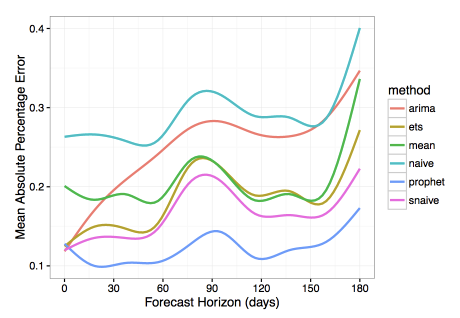

In [2]:
from PIL import Image
img = Image.open('prophet_comparrison.png')
img

In [3]:
df_full = pd.read_csv('data/df_full_clean.csv')

In [4]:
df_full['utc_event_time'] = pd.to_datetime(df_full['utc_event_time'])
df_full['utc_event_date'] = pd.to_datetime(df_full['utc_event_date'])

In [5]:
df_purchase = df_full.query('ecom_event_action == "purchase"')

<AxesSubplot:>

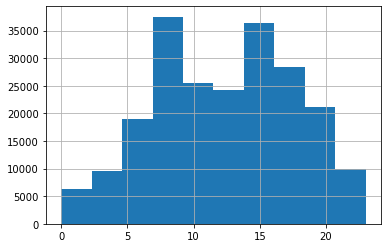

In [6]:
# You can see the peaks by the hour. 2 Peaks is possible because the regions of Russia are located in different time zones (up to 8 hours difference)
# And that's 2 peaks, let's say locally at 8pm in each region
df_purchase['utc_event_time'].dt.hour.hist()

<AxesSubplot:>

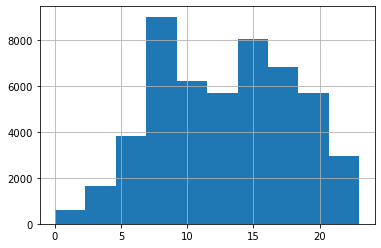

In [7]:
# The hypothesis was not confirmed. Moscow also has 2 peak hours. So most sales happen at 9 am and 3 pm
df_purchase.query('city_name == "Москва"')['utc_event_time'].dt.hour.hist()

In [8]:
grp_daily_sales_qty = df_purchase.groupby('utc_event_date', as_index=False) \
                                .agg({'ecom_qty': 'sum'})

In [9]:
import holidays
# We throw holidays, for their accounting with a model
holidays_dict = holidays.RU(years=(2021, 2022))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.head()

ds    holiday
0 2021-01-01  Новый год
1 2021-01-02  Новый год
2 2021-01-03  Новый год
3 2021-01-04  Новый год
4 2021-01-05  Новый год

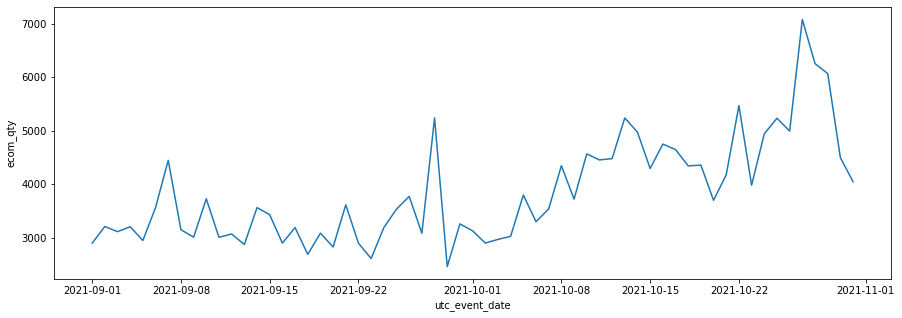

In [10]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=grp_daily_sales_qty, x='utc_event_date', y='ecom_qty');

In [11]:
grp_daily_sales_for_prophet = grp_daily_sales_qty.rename(columns={'utc_event_date': 'ds', 
                                                                  'ecom_qty': 'y'})

In [12]:
# The period we need to cut off and predict (model check)
predictions = 14

# Cut off the last N points from the training sample to measure the quality on them
train_df = grp_daily_sales_for_prophet[:-predictions]
train_df.tail()

ds     y
42 2021-10-13  5239
43 2021-10-14  4973
44 2021-10-15  4296
45 2021-10-16  4752
46 2021-10-17  4650

In [13]:
# Set up prophet - tell him to take into account holidays and seasonality
# Since the data is only 2 months old, it is unfortunately not possible to add yearly seasonality
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
m.fit(train_df)

In [14]:
# Predict 30 days
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

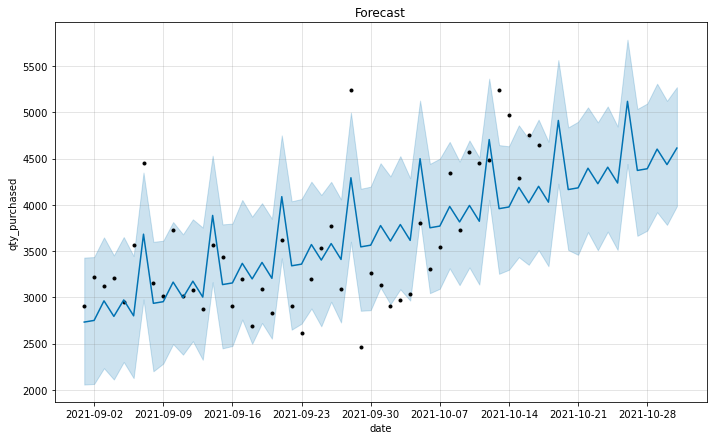

In [23]:
m.plot(forecast)
plt.title('Forecast')
plt.xlabel('date')
plt.ylabel('qty_purchased');

uptrend
The holiday factor did not detect jumps (because an open library was taken, where there are few thematic events and there are no non-state generally accepted events that significantly affect sales - Black Friday, St. Valentine's Day ...). If you collect more complete data about holidays and events, you can significantly improve the model.
There is seasonality within the week.

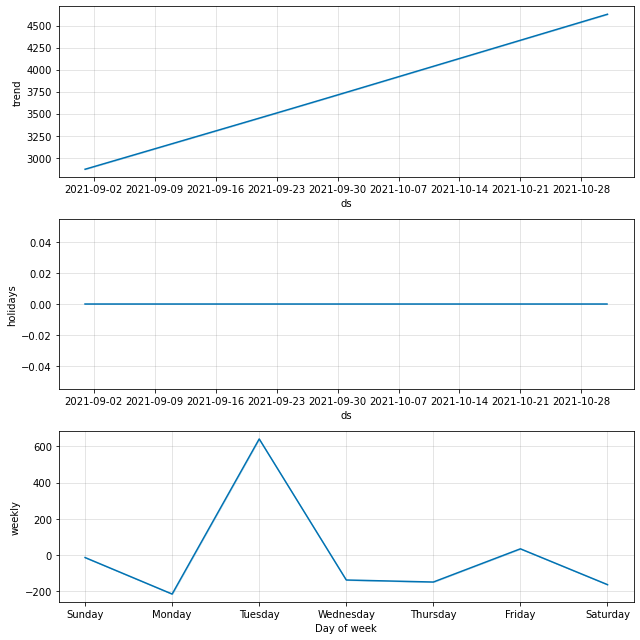

In [29]:
m.plot_components(forecast);

**Model accuracy is 14.2%**

In [17]:
# Look at model errors
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(grp_daily_sales_for_prophet.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  14.155417266211922 %
MAE (средняя абсолютная ошибка) –  783.4431239959277


In [18]:
# Forecast for the full period (specify the number of days)
prediction_days = 30
final_train_df = grp_daily_sales_for_prophet
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

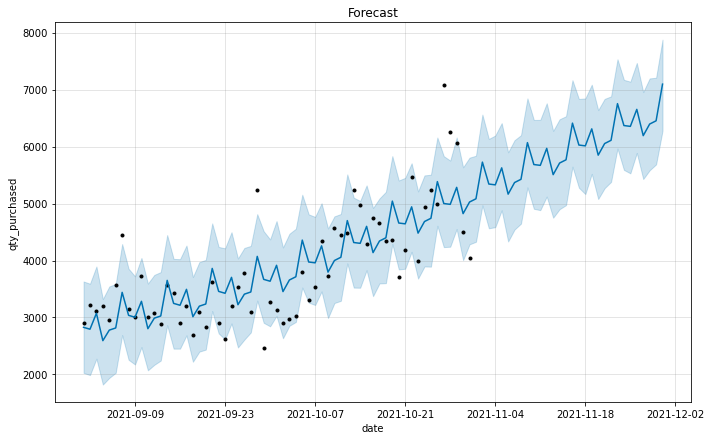

In [30]:
# We look at what was predicted for the full period
f.plot(final_forecast)
plt.title('Forecast')
plt.xlabel('date')
plt.ylabel('qty_purchased');

In [20]:
df_purchase

utc_event_time utc_event_date               user_id city_name  \
99      2021-10-30 17:22:10     2021-10-30  11715549676869303403    Самара   
101     2021-10-30 17:30:40     2021-10-30  11715549676869303403    Самара   
114     2021-10-21 14:09:28     2021-10-21   9965105300024501182    Москва   
115     2021-10-21 14:09:28     2021-10-21   9965105300024501182    Москва   
116     2021-10-21 14:09:28     2021-10-21   9965105300024501182    Москва   
...                     ...            ...                   ...       ...   
3449864 2021-10-10 14:31:14     2021-10-10  12234373371050787914  Владимир   
3449870 2021-10-10 17:40:56     2021-10-10  11010074957608815658       NaN   
3449882 2021-10-10 10:33:09     2021-10-10  12506568739029030800    Москва   
3450040 2021-10-10 16:56:33     2021-10-10  12700475914126527276    Москва   
3450041 2021-10-10 16:56:33     2021-10-10  12700475914126527276    Москва   

        ecom_event_action                           ecom_id  \
99               purchase  BDBD23C5359EF7B3F85763C032892B85   
101              purchase  BDBD23C5359EF7B3F85763C032892B85   
114              purchase  6EB3A8836EBDF486669F65CA40FCB6D9   
115              purchase  C0C9F2DC21904776545FFBB2FC3D646C   
116              purchase  6614542C68CA1F63F168B25FC75D6001   
...                   ...                               ...   
3449864          purchase  ECD8847A3E389369BA25918DFF9B5B83   
3449870          purchase  C0C9F2DC21904776545FFBB2FC3D646C   
3449882          purchase  AF51FBD3B09A5BE324C76C524118BFD3   
3450040          purchase  9EC302050B63C90533F9FFBCAC489DD8   
3450041          purchase  4471C612A8DC0B56607EBED79E3FA3B9   

                                                ecom_brand  \
99                        0B1BC368C77D7A9B58F26B087958C231   
101                       0B1BC368C77D7A9B58F26B087958C231   
114                       12D89E762536342E35B5F410066B0B45   
115                       A1311DE377A4D46E27D2AE29A4755DB8   
116                       BF6C2D5F4A28EE8D6451DEC5A5435258   
...                                                    ...   
3449864                   1A741328B5C5DF34FE89D28EB1AD01A2   
3449870                   A1311DE377A4D46E27D2AE29A4755DB8   
3449882                   27FE65559334F3F5EE107A8F324F46D0   
3450040  A045311D713A9F98D5DBEE79D58CF7F806A50A1B0F92C3...   
3450041                   7F39173DE4DD955DE98C28BEBABF1F76   

                                              ecom_variant ecom_currency  \
99                        7948A713612D01DC921228E236CAA06A           RUB   
101                       7948A713612D01DC921228E236CAA06A           RUB   
114                       50D05F0ABB80F2B62C5F67F057E88D5F           RUB   
115                       3B9A6121A509CBADC049AEABD3ED0223           RUB   
116                       50D05F0ABB80F2B62C5F67F057E88D5F           RUB   
...                                                    ...           ...   
3449864  56FFD2E0EFC4BDD7FCEF09AB6197CC83222B1AC6B5CDDB...           RUB   
3449870                   3B9A6121A509CBADC049AEABD3ED0223           RUB   
3449882                   50D05F0ABB80F2B62C5F67F057E88D5F           RUB   
3450040                   77544CB78DD75439AC036C9EA66445A6           RUB   
3450041                   0390E36F0FEB3BECB16F22362259FF43           RUB   

         ecom_price100  ecom_qty  ecom_grand_total100 os_manufacturer  \
99           2327600.0         1            2327600.0          HUAWEI   
101          2327600.0         1            2327600.0          HUAWEI   
114            38900.0         1              38900.0          Xiaomi   
115            15400.0         1              15400.0          Xiaomi   
116            23600.0         1              23600.0          Xiaomi   
...                ...       ...                  ...             ...   
3449864       233200.0         1             233200.0         samsung   
3449870        17000.0         2              34000.0         samsung   
3449